# Predicting Skin Cancer Types
#### Fall 2024
#### Team: Mei Qu, Sonia Song, Jefferson Jules

``Objective``
* Perform multiclass classification 

``Motivation``
* 

``Data``

* The [Skin Cancer MNIST: HAM10000](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000/data) contains a large collection of multi-source dermatoscopic images of pigmented lesions (Source: Kaggle).

### Import libraries

In [1]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from glob import glob
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
import seaborn as sns
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')

### Define functions

In [2]:
def read_data(input):
    ''''''
    # Read data
    df = pd.read_csv(
        input,
        sep=",",
        encoding='latin-1'
    )
    
    return df

---
### Step 1: Data ingestion

In [3]:
df = read_data('./data/HAM10000_metadata.csv')
df_rgb_8 = pd.read_csv('./data/hmnist_8_8_RGB.csv')
df_l_8 = pd.read_csv('./data/hmnist_8_8_L.csv')
df_rgb_28 = pd.read_csv('./data/hmnist_28_28_RGB.csv')
df_l_28 = pd.read_csv('./data/hmnist_28_28_L.csv')
print('Shape of metadata data', df.shape)
print('Shape of RGB 8x8 data', df_rgb_8.shape)
print('Shape of L 8x8 data', df_l_8.shape)
print('Shape of RGB 28x28 data', df_rgb_28.shape)
print('Shape of L 28x28 data', df_l_28.shape)
df.head()

Shape of metadata data (10015, 7)
Shape of RGB 8x8 data (10015, 193)
Shape of L 8x8 data (10015, 65)
Shape of RGB 28x28 data (10015, 2353)
Shape of L 28x28 data (10015, 785)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
# Create a dictionary mapping abbreviated lesion type codes to their full descriptive names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
# Add column in metadata dataset to full path to each image
base_skin_dir = './data'
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))
}
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type']=df['dx'].map(lesion_type_dict.get)
df['cell_type_idx']=pd.Categorical(df['cell_type']).codes 
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                             path  \
0         ./data/HAM10000_images/ISIC_0027419.jpg   
1         ./data/HAM10000_images/ISIC_0025030.jpg   
2         ./data/HAM10000_images/ISIC_0026769.jpg   
3         ./data/HAM10000_images/ISIC_0025661.jpg   
4  ./data/HAM10000_images_part_2/ISIC_0031633.jpg   

                       cell_type  cell_type_idx  
0  Benign keratosis-like lesions              2  
1  Benign keratosis-like lesions              2  
2  Benign keratosis-like lesions              2  
3  Benign keratosis-like lesions              2  
4  Benign 

---
### Step 2: Getting to Know the Data

In [5]:
# YOUR CODE HERE
num_rows, num_cols = df.shape
print(f"1. There are {num_cols} columns in the metadata dataset")
print(f"2. There are {num_rows} rows in the metadata dataset")
print(f"3. Column names:", df.columns.tolist())
print("4. ")
for col in df.columns:
    print(f"Unique values in {col}: {df[col].nunique()}")
print('5. NA values:')
print(df.isna().sum())

1. There are 10 columns in the metadata dataset
2. There are 10015 rows in the metadata dataset
3. Column names: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'path', 'cell_type', 'cell_type_idx']
4. 
Unique values in lesion_id: 7470
Unique values in image_id: 10015
Unique values in dx: 7
Unique values in dx_type: 4
Unique values in age: 18
Unique values in sex: 3
Unique values in localization: 15
Unique values in path: 10015
Unique values in cell_type: 7
Unique values in cell_type_idx: 7
5. NA values:
lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64


---
### Step 3: Choosing the Prediction Task

My outcome variable will be cell_type


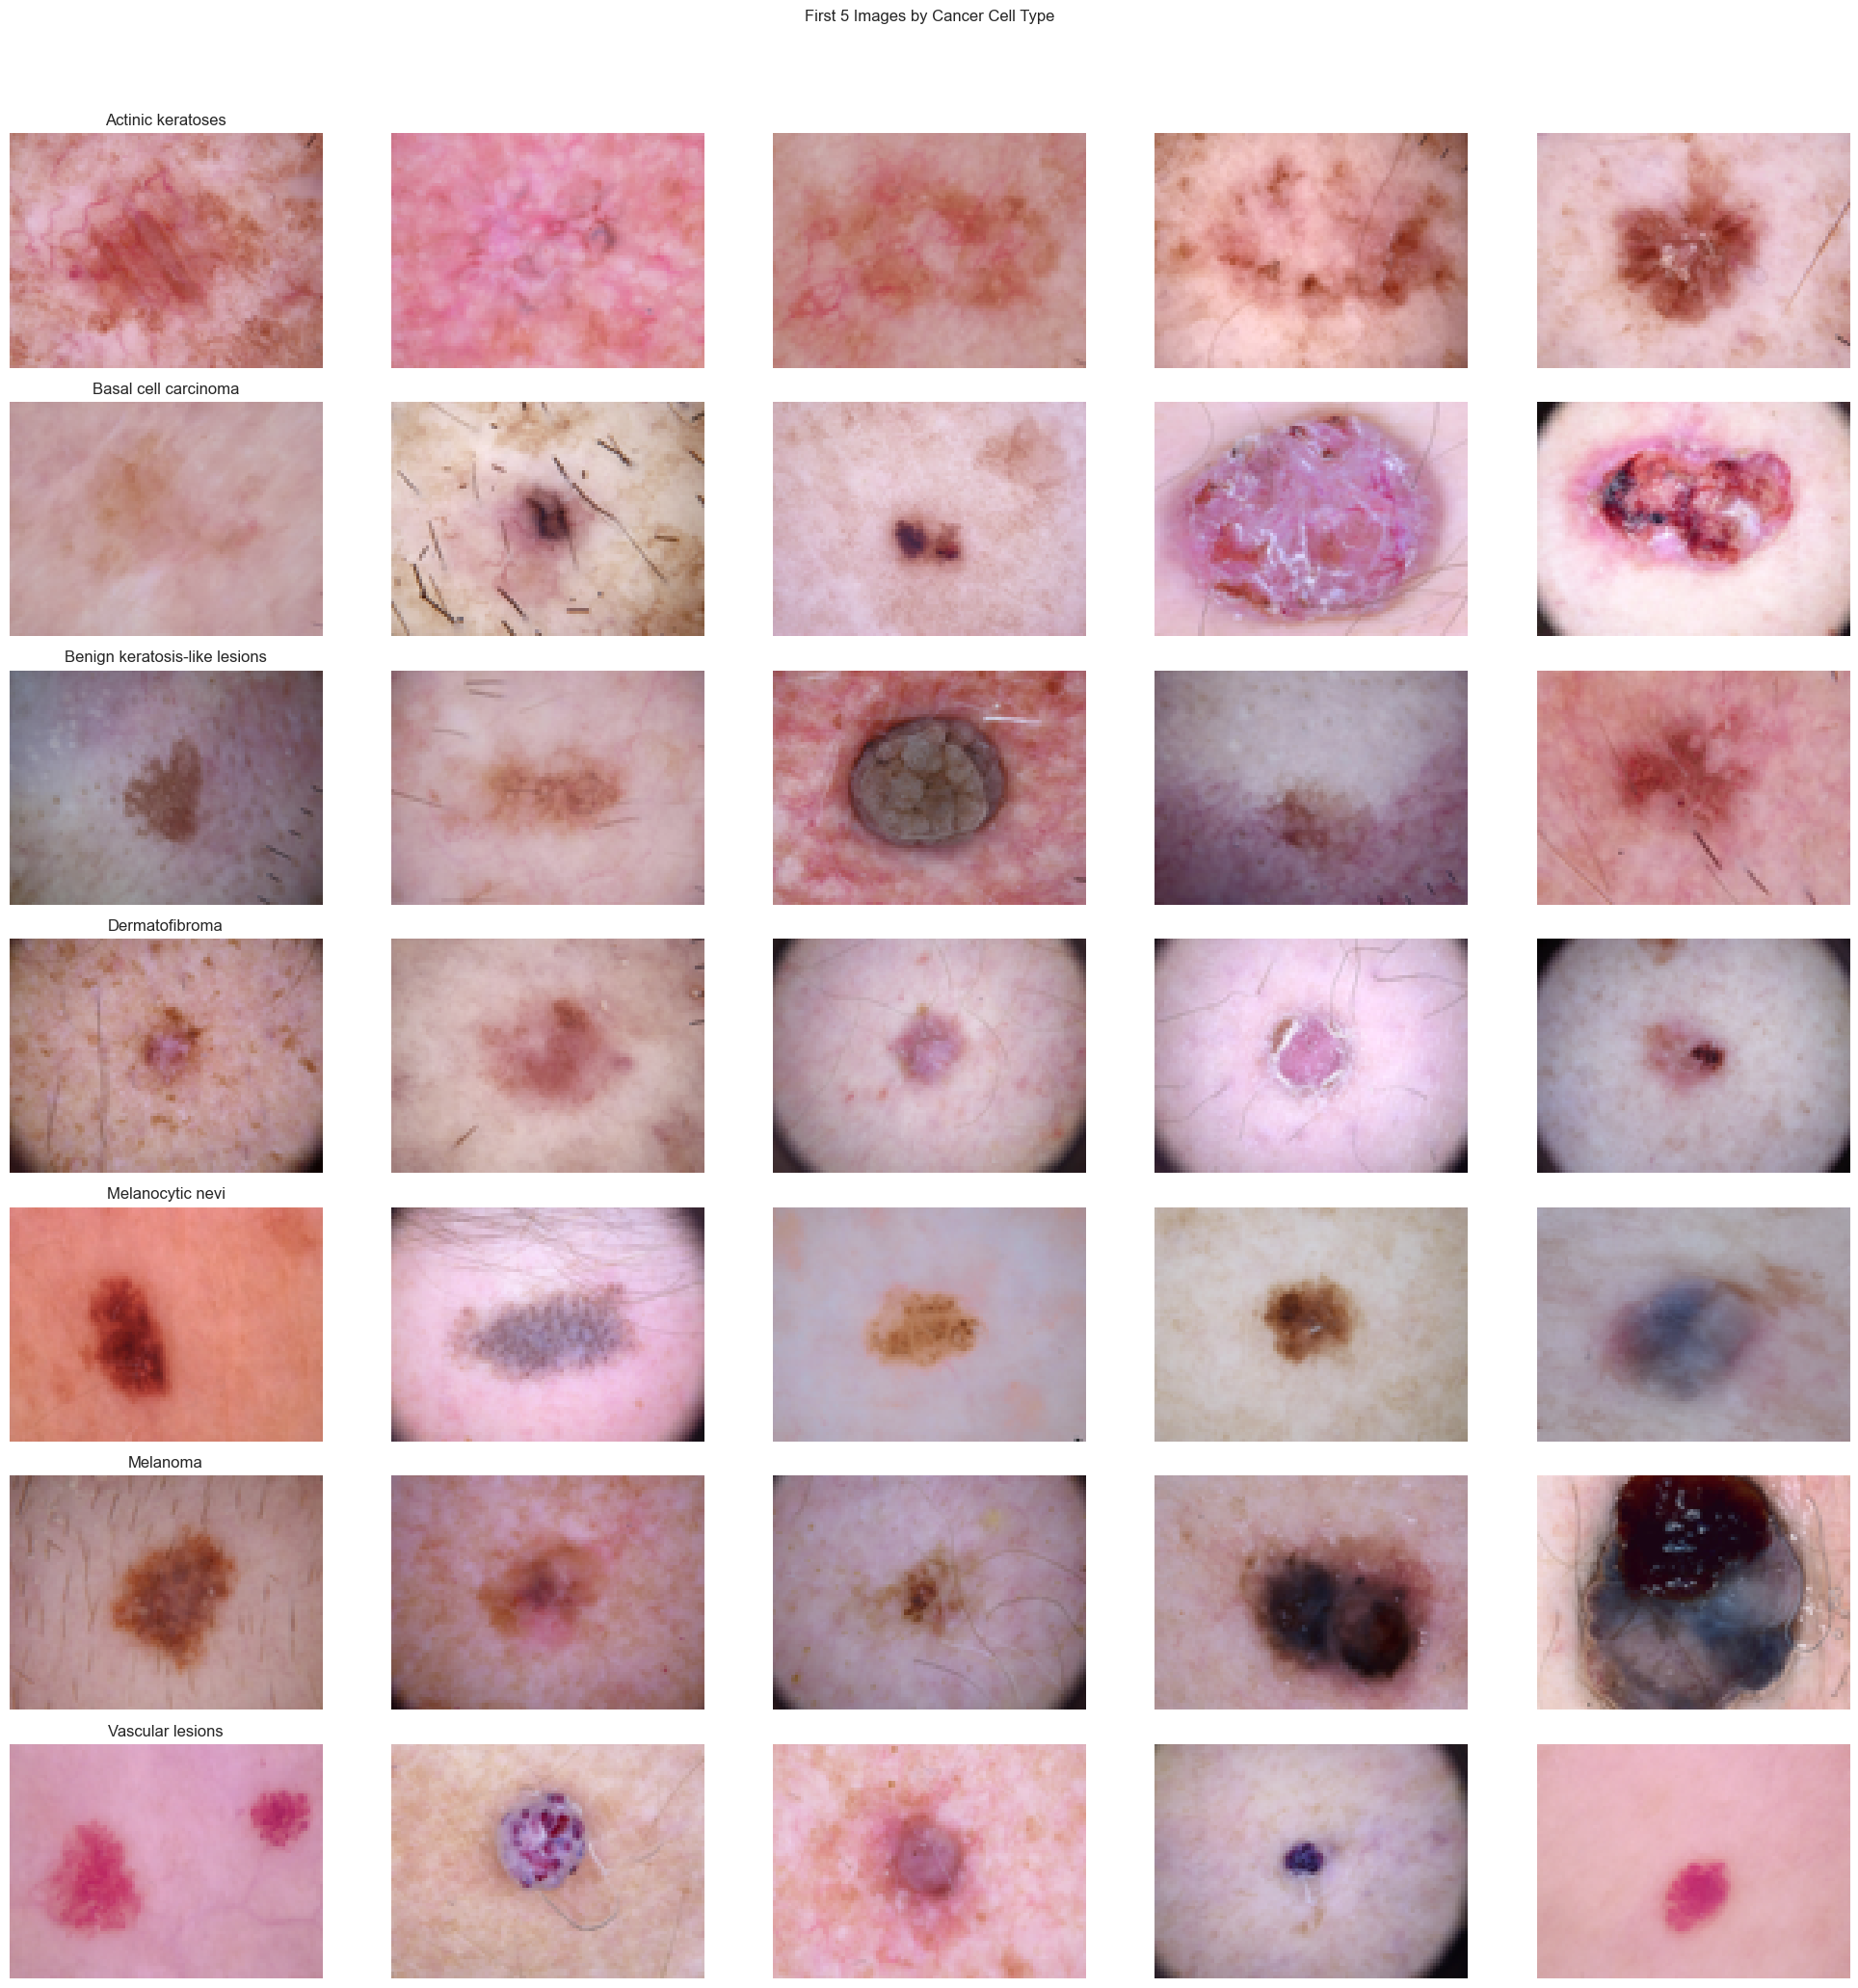

In [49]:
print("My outcome variable will be cell_type")
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))
fig.suptitle("First 5 Images by Cancer Cell Type")
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

---
### Step 4: Data Preprocessing

1. Shuffle the dataset;
2. Create training, validation, and test datasets using a 60/20/20 split;
3. Identify the features of interest;
4. Perform necessary cleaning and standarization on the features.

In [6]:
# YOUR CODE HERE
np.random.seed(0)

def shuffle_and_split_dataframe(df, test_size=0.2, val_size=0.25, random_state=1234):
    num_samples = df.shape[0]
    shuffled_indices = np.random.permutation(num_samples)
    print("Shuffled Indices:", shuffled_indices)
    df = df.iloc[shuffled_indices]
    train_val_df, test = train_test_split(df, test_size=test_size, random_state=random_state)
    train, val = train_test_split(train_val_df, test_size=val_size, random_state=random_state)
    return train, val, test

def standarize_image(image_path, size):
    img = load_img(image_path, target_size=(size, size))
    img = img_to_array(img) / 255.0
    return img

def preprocess_data_custom(df, image_size):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        image_path = row['path']
        
        if image_path:
            img = standarize_image(image_path, image_size)
            images.append(img)
            labels.append(row['cell_type'])
        else:
            print(f"Can't find {image_path}")
    
    images = np.array(images)
    
    # Binarize labels
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    
    return images, labels

def preprocess_data(df, image_size, is_rgb=True):
    # Load the CSV data
    
    images = []
    labels = []

    for index, row in df.iterrows():
        # Extract pixel data
        image_data = row[:-1].values  # All pixel values except the last column
        label = row[-1]  # Last column is the label
        
        # Reshape pixel data dynamically based on whether it's RGB or grayscale
        if is_rgb:
            # For RGB images, reshape to (image_size, image_size, 3)
            img = image_data.reshape(image_size, image_size, 3)  # Change the last dimension as needed
        else:
            # For grayscale images, reshape to (image_size, image_size)
            img = image_data.reshape(image_size, image_size, 1)
            
        img = img / 255.0

        images.append(img)
        labels.append(label)
    
    labels = to_categorical(labels, 7)

    return np.array(images), np.array(labels)

Process Custom Image Size Data

Shuffled Indices: [6144 4658 7653 ... 3264 9845 2732]
Train 128 x 128 images shape: (6009, 128, 128, 3), Train labels shape: (6009, 7)
Validation 128 x 128 images shape: (2003, 128, 128, 3), Validation labels shape: (2003, 7)
Test 128 x 128 images shape: (2003, 128, 128, 3), Test labels shape: (2003, 7)


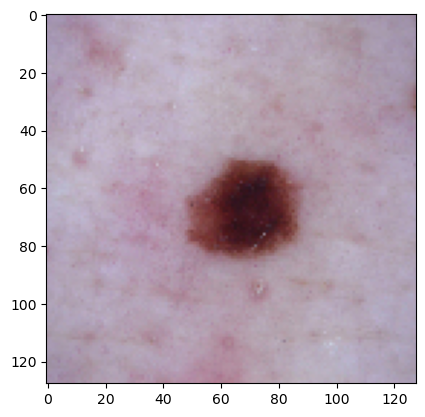

In [7]:
tf.random.set_seed(207)
# Target image size, try different sizes
IMAGE_SIZE = 128

train_custom, val_custom, test_custom = shuffle_and_split_dataframe(df)

train_images_custom, train_labels_custom = preprocess_data_custom(train_custom, IMAGE_SIZE)
val_images_custom, val_labels_custom = preprocess_data_custom(val_custom, IMAGE_SIZE)
test_images_custom, test_labels_custom = preprocess_data_custom(test_custom, IMAGE_SIZE)

print(f"Train {IMAGE_SIZE} x {IMAGE_SIZE} images shape: {train_images_custom.shape}, Train labels shape: {train_labels_custom.shape}")
print(f"Validation {IMAGE_SIZE} x {IMAGE_SIZE} images shape: {val_images_custom.shape}, Validation labels shape: {val_labels_custom.shape}")
print(f"Test {IMAGE_SIZE} x {IMAGE_SIZE} images shape: {test_images_custom.shape}, Test labels shape: {test_labels_custom.shape}")
plt.imshow(train_images_custom[0])
plt.show()


Process RGB 8x8 Image Data

Shuffled Indices: [9767 5072 5031 ... 5574 7408 1942]
Train 8 x 8 RGB images shape: (6009, 8, 8, 3), Train 8 x 8 RGB labels shape: (6009, 7)
Validation 8 x 8 RGB images shape: (2003, 8, 8, 3), Validation 8 x 8 RGB labels shape: (2003, 7)
Test 8 x 8 RGB images shape: (2003, 8, 8, 3), Test 8 x 8 RGB labels shape: (2003, 7)


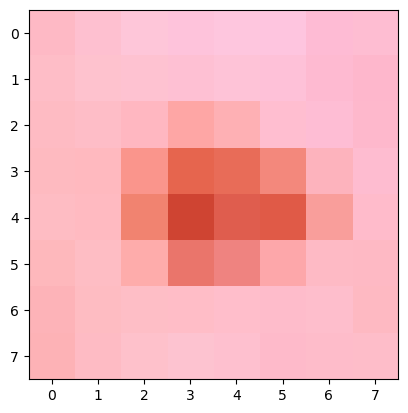

In [8]:
tf.random.set_seed(207)
train_rgb_8, val_rgb_8, test_rgb_8 = shuffle_and_split_dataframe(df_rgb_8)

train_images_rgb_8, train_labels_rgb_8 = preprocess_data(train_rgb_8, 8)
val_images_rgb_8, val_labels_rgb_8 = preprocess_data(val_rgb_8, 8)
test_images_rgb_8, test_labels_rgb_8 = preprocess_data(test_rgb_8, 8)

print(f"Train 8 x 8 RGB images shape: {train_images_rgb_8.shape}, Train 8 x 8 RGB labels shape: {train_labels_rgb_8.shape}")
print(f"Validation 8 x 8 RGB images shape: {val_images_rgb_8.shape}, Validation 8 x 8 RGB labels shape: {val_labels_rgb_8.shape}")
print(f"Test 8 x 8 RGB images shape: {test_images_rgb_8.shape}, Test 8 x 8 RGB labels shape: {test_labels_rgb_8.shape}")
plt.imshow(train_images_rgb_8[0])
plt.show()

Process Grayscale 8x8 Image Data

Shuffled Indices: [8822 5618 1006 ... 1492 4225 9580]
Train 8 x 8 Grayscale images shape: (6009, 8, 8, 1), Train 8 x 8 Grayscale labels shape: (6009, 7)
Validation 8 x 8 Grayscale images shape: (2003, 8, 8, 1), Validation 8 x 8 Grayscale labels shape: (2003, 7)
Test 8 x 8 Grayscale images shape: (2003, 8, 8, 1), Test 8 x 8 Grayscale labels shape: (2003, 7)


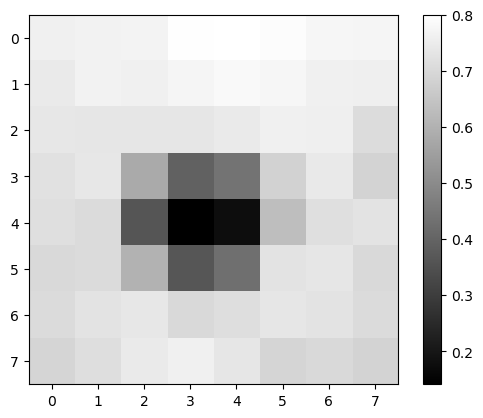

In [9]:
tf.random.set_seed(207)
train_l_8, val_l_8, test_l_8 = shuffle_and_split_dataframe(df_l_8)

train_images_l_8, train_labels_l_8 = preprocess_data(train_l_8, 8, False)
val_images_l_8, val_labels_l_8 = preprocess_data(val_l_8, 8, False)
test_images_l_8, test_labels_l_8 = preprocess_data(test_l_8, 8, False)

print(f"Train 8 x 8 Grayscale images shape: {train_images_l_8.shape}, Train 8 x 8 Grayscale labels shape: {train_labels_l_8.shape}")
print(f"Validation 8 x 8 Grayscale images shape: {val_images_l_8.shape}, Validation 8 x 8 Grayscale labels shape: {val_labels_l_8.shape}")
print(f"Test 8 x 8 Grayscale images shape: {test_images_l_8.shape}, Test 8 x 8 Grayscale labels shape: {test_labels_l_8.shape}")
plt.imshow(train_images_l_8[0], cmap="gray")
plt.colorbar()
plt.show()

Process RGB 28x28 Image Data

Shuffled Indices: [ 271 8444 5965 ... 9587 6984 2586]
Train 28 x 28 RGB images shape: (6009, 28, 28, 3), Train 28 x 28 RGB labels shape: (6009, 7)
Validation 28 x 28 RGB images shape: (2003, 28, 28, 3), Validation labels 28 x 28 RGB shape: (2003, 7)
Test 28 x 28 RGB images shape: (2003, 28, 28, 3), Test 28 x 28 RGB labels shape: (2003, 7)


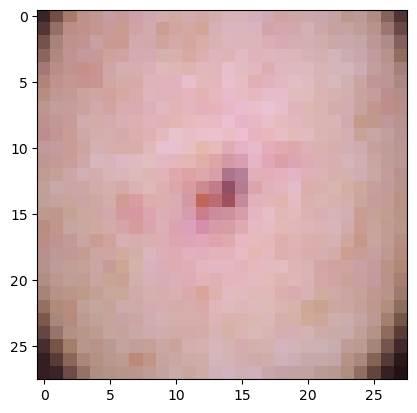

In [10]:
tf.random.set_seed(207)
train_rgb_28, val_rgb_28, test_rgb_28 = shuffle_and_split_dataframe(df_rgb_28)

train_images_rgb_28, train_labels_rgb_28 = preprocess_data(train_rgb_28, 28)
val_images_rgb_28, val_labels_rgb_28 = preprocess_data(val_rgb_28, 28)
test_images_rgb_28, test_labels_rgb_28 = preprocess_data(test_rgb_28, 28)

print(f"Train 28 x 28 RGB images shape: {train_images_rgb_28.shape}, Train 28 x 28 RGB labels shape: {train_labels_rgb_28.shape}")
print(f"Validation 28 x 28 RGB images shape: {val_images_rgb_28.shape}, Validation labels 28 x 28 RGB shape: {val_labels_rgb_28.shape}")
print(f"Test 28 x 28 RGB images shape: {test_images_rgb_28.shape}, Test 28 x 28 RGB labels shape: {test_labels_rgb_28.shape}")
plt.imshow(train_images_rgb_28[0])
plt.show()

Process Grayscale 28x28 Image Data

Shuffled Indices: [1816 8919 7411 ... 7178 2169 9162]
Train 28 x 28 Grayscale images shape: (6009, 28, 28, 1), Train 28 x 28 Grayscale labels shape: (6009, 7)
Validation 28 x 28 Grayscale images shape: (2003, 28, 28, 1), Validation 28 x 28 Grayscale labels shape: (2003, 7)
Test 28 x 28 Grayscale images shape: (2003, 28, 28, 1), Test 28 x 28 Grayscale labels shape: (2003, 7)


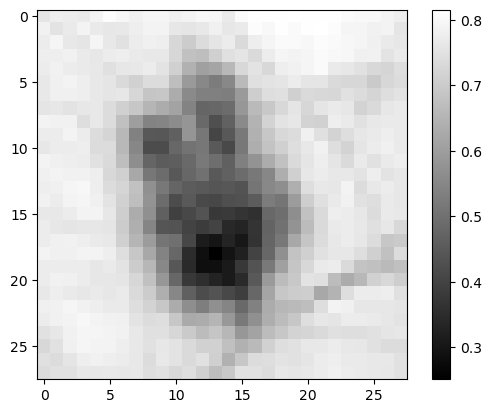

In [11]:
tf.random.set_seed(207)
train_l_28, val_l_28, test_l_28 = shuffle_and_split_dataframe(df_l_28)

train_images_l_28, train_labels_l_28 = preprocess_data(train_l_28, 28, False)
val_images_l_28, val_labels_l_28 = preprocess_data(val_l_28, 28, False)
test_images_l_28, test_labels_l_28 = preprocess_data(test_l_28, 28, False)

print(f"Train 28 x 28 Grayscale images shape: {train_images_l_28.shape}, Train 28 x 28 Grayscale labels shape: {train_labels_l_28.shape}")
print(f"Validation 28 x 28 Grayscale images shape: {val_images_l_28.shape}, Validation 28 x 28 Grayscale labels shape: {val_labels_l_28.shape}")
print(f"Test 28 x 28 Grayscale images shape: {test_images_l_28.shape}, Test 28 x 28 Grayscale labels shape: {test_labels_l_28.shape}")
plt.imshow(train_images_l_28[0], cmap="gray")
plt.colorbar()
plt.show()

---
### Step 5: Exploratory data analysis (EDA)

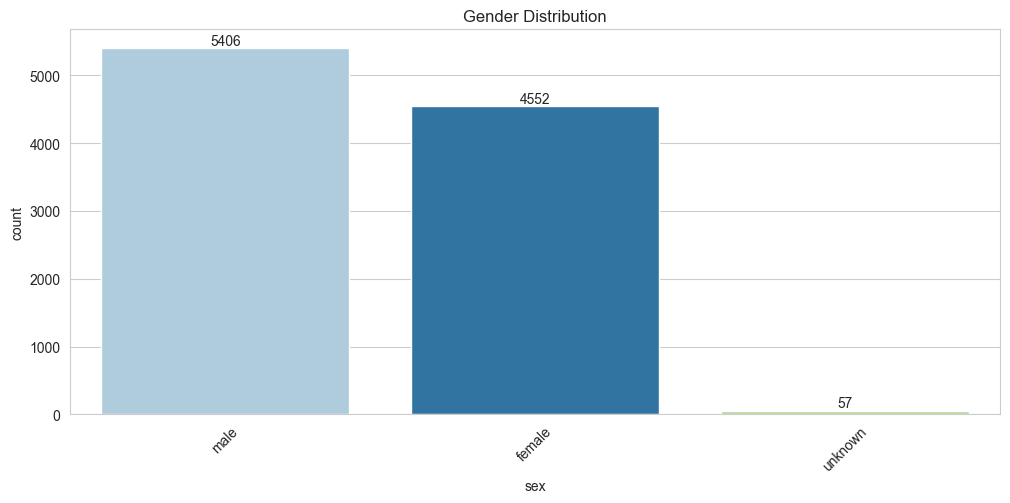

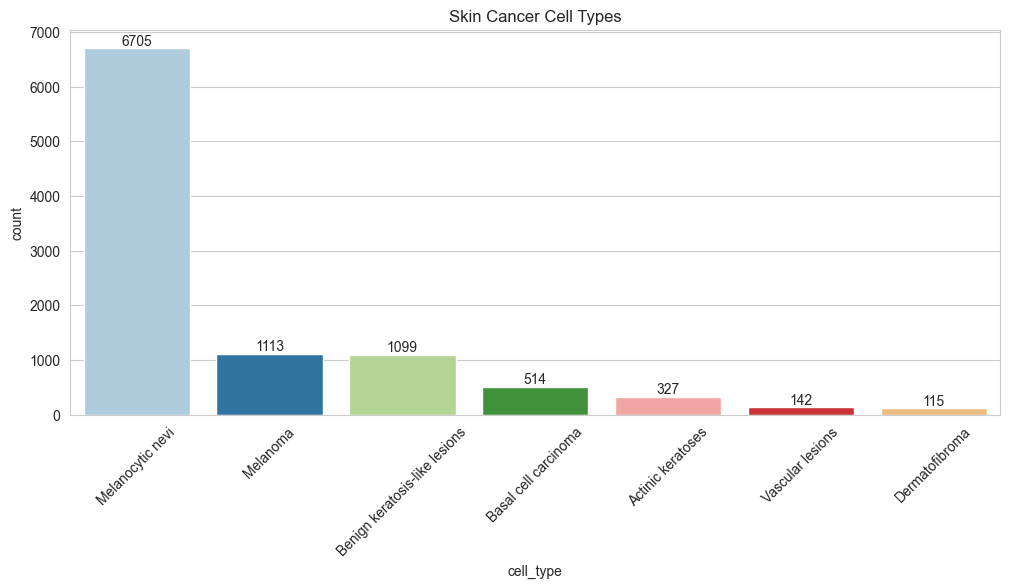

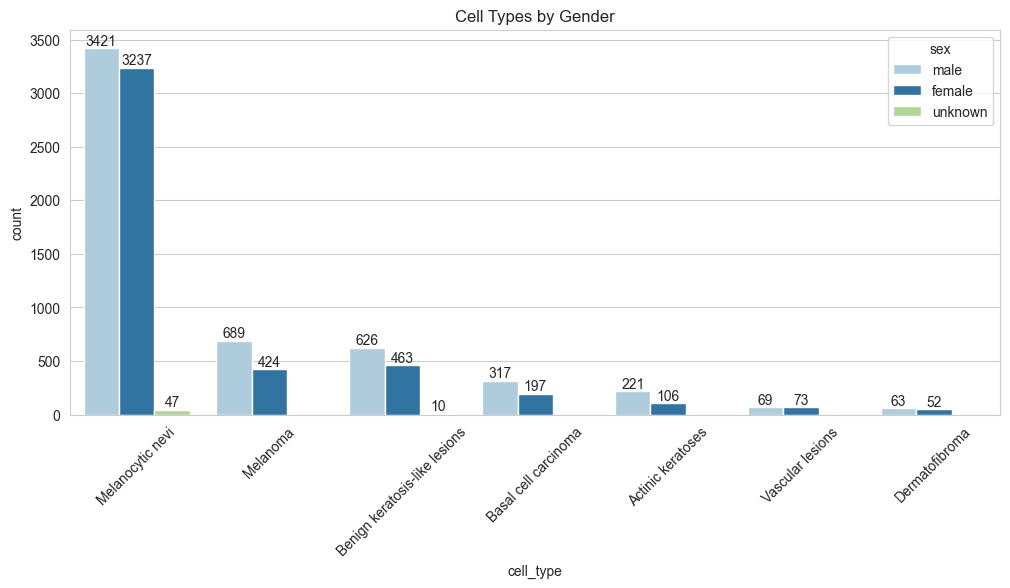

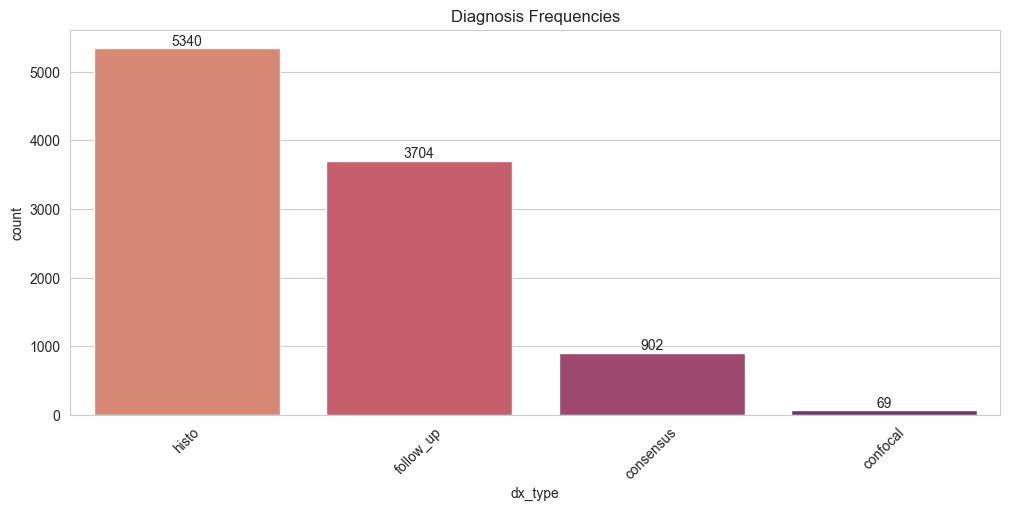

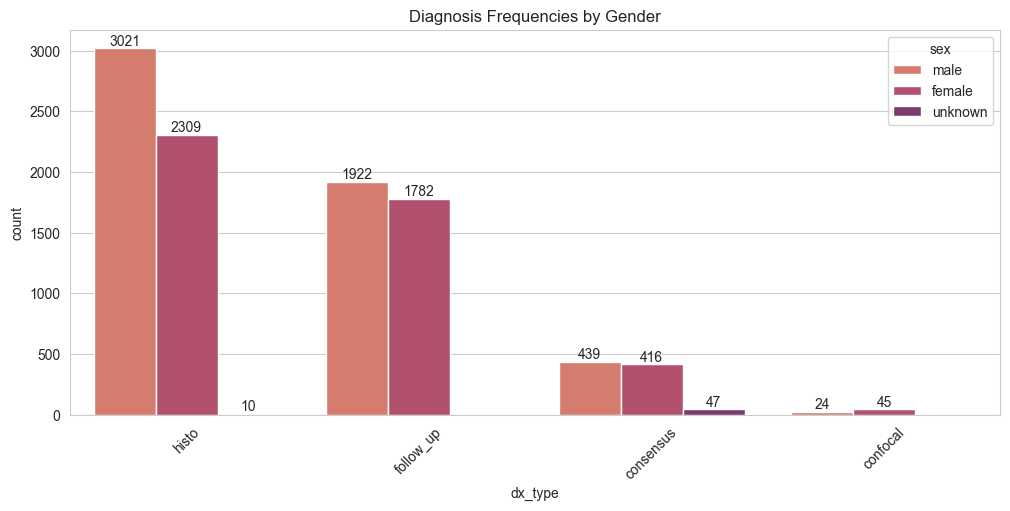

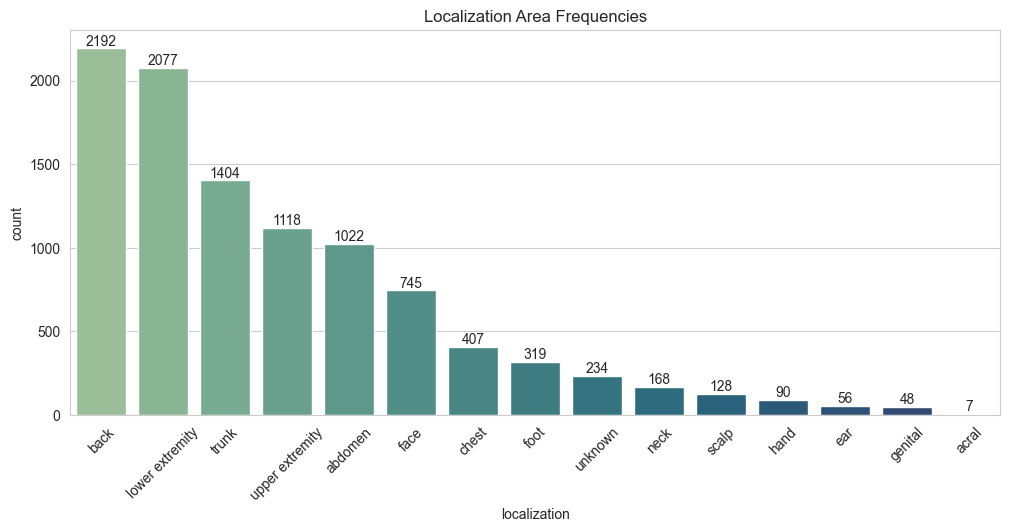

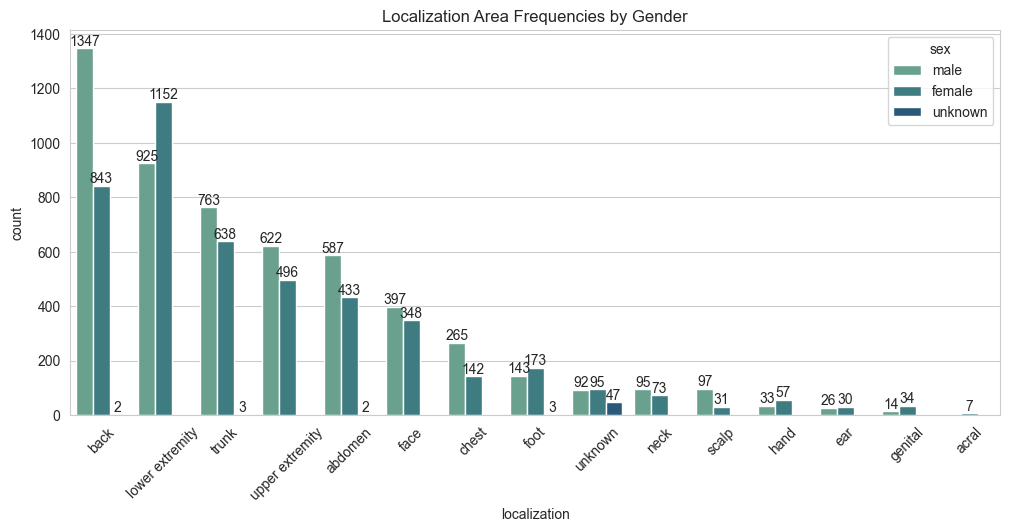

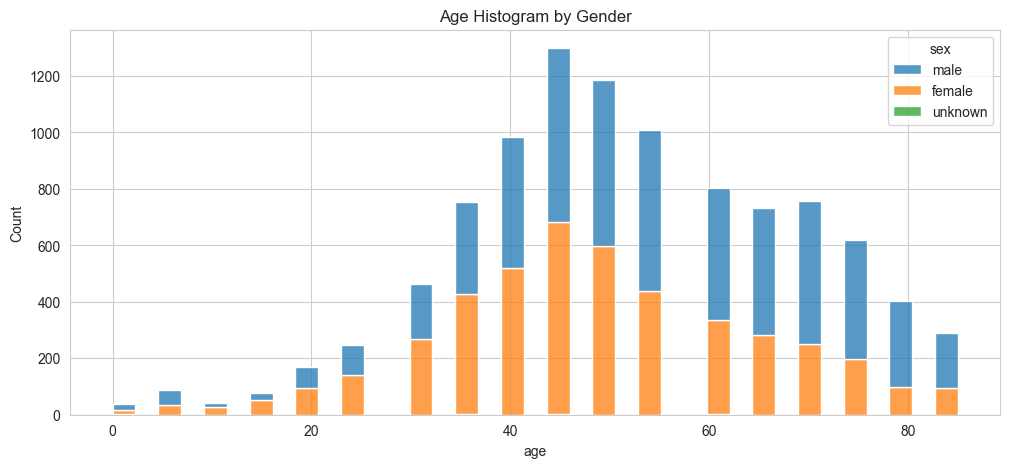

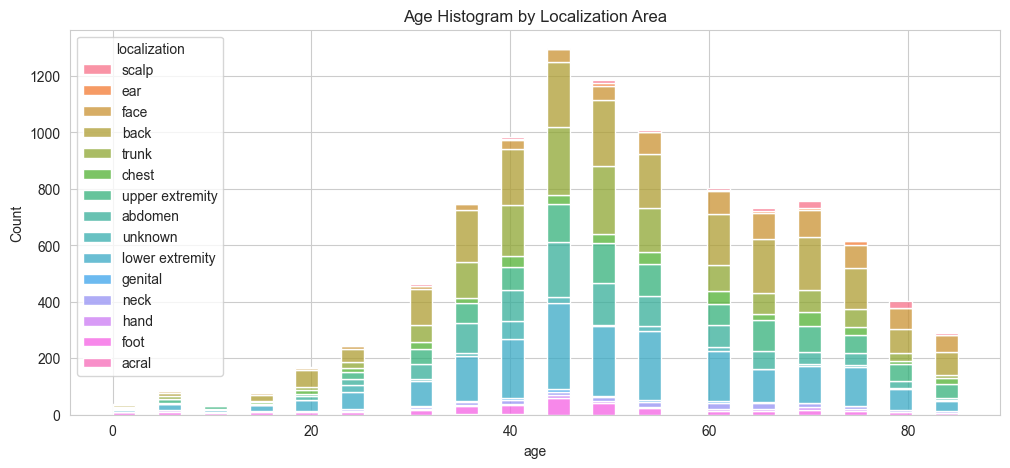

In [56]:
sns.set_style('whitegrid')

# Helper function to create count plots
def create_count_plot(x, hue=None, title='', palette='Paired', order=None, rotation=45):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax = sns.countplot(x=x, hue=hue, data=df, order=order, palette=palette)
    for container in ax.containers:
        ax.bar_label(container)
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.show()

# Helper function to create histogram plots
def create_hist_plot(x, hue=None, title=''):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax = sns.histplot(data=df, x=x, hue=hue, multiple='stack')
    plt.title(title)
    plt.show()

# Plot each visualization
create_count_plot(x='sex', title='Gender Distribution', palette='Paired')
create_count_plot(x='cell_type', title='Skin Cancer Cell Types', order=df['cell_type'].value_counts().index, palette='Paired')
create_count_plot(x='cell_type', hue='sex', title='Cell Types by Gender', order=df['cell_type'].value_counts().index, palette='Paired')
create_count_plot(x='dx_type', title='Diagnosis Frequencies', order=df['dx_type'].value_counts().index, palette='flare')
create_count_plot(x='dx_type', hue='sex', title='Diagnosis Frequencies by Gender', order=df['dx_type'].value_counts().index, palette='flare')
create_count_plot(x='localization', title='Localization Area Frequencies', order=df['localization'].value_counts().index, palette='crest')
create_count_plot(x='localization', hue='sex', title='Localization Area Frequencies by Gender', order=df['localization'].value_counts().index, palette='crest')
create_hist_plot(x='age', hue='sex', title='Age Histogram by Gender')
create_hist_plot(x='age', hue='localization', title='Age Histogram by Localization Area')


In [57]:
#Pairplot 

# Assuming pixel columns are named pixel_1, pixel_2, ..., pixel_n
#pixel_columns = [f'pixel_{i}' for i in range(0, 63+1)]  # Replace 'n' with the number of pixels

# Calculate average pixel values
#df['average_pixel'] = df[pixel_columns].mean(axis=1)

# Select the columns for the pairplot, including average pixel and relevant metadata
# pairplot_data = df[['dx', 'dx_type', 'age', 'sex', 'localization', 'cell_type', 'cell_type_idx']]
# pairplot_data['dx'] = pd.Categorical(pairplot_data['dx'])
# pairplot_data['sex'] = pd.Categorical(pairplot_data['sex'])
# #pairplot_data['localization'] = pd.Categorical(pairplot_data['localization'])
# #pairplot_data['cell_type'] = pd.Categorical(pairplot_data['cell_type'])

# import seaborn as sns
# import matplotlib.pyplot as plt

# print(pairplot_data.head())
# # Create a pairplot
# sns.pairplot(pairplot_data, diag_kind='kde')  # Use 'hue' for color coding by cell type

# # Show the plot
# plt.show()

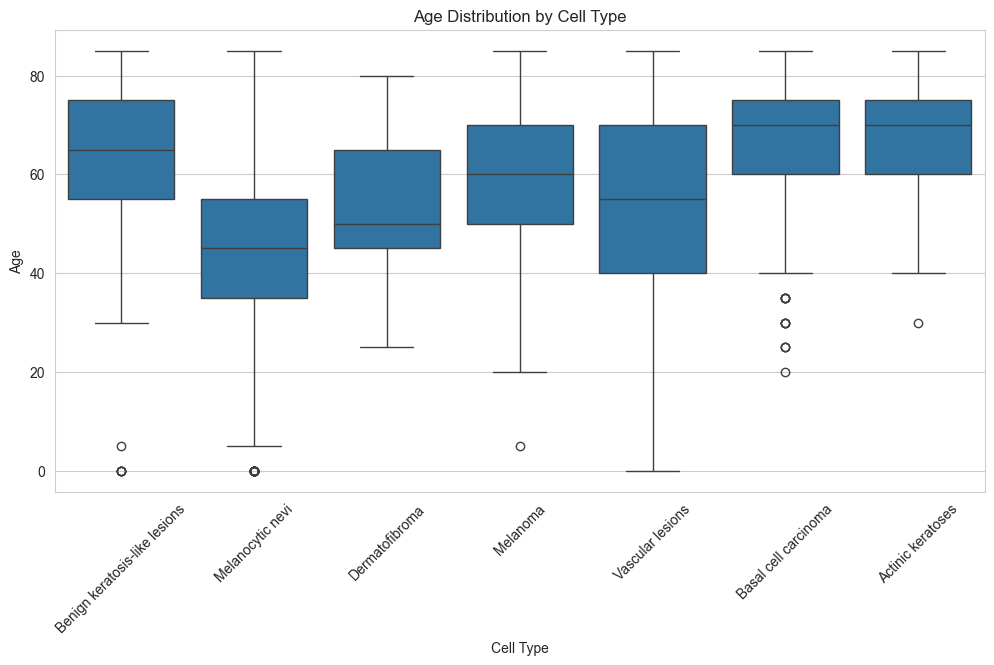

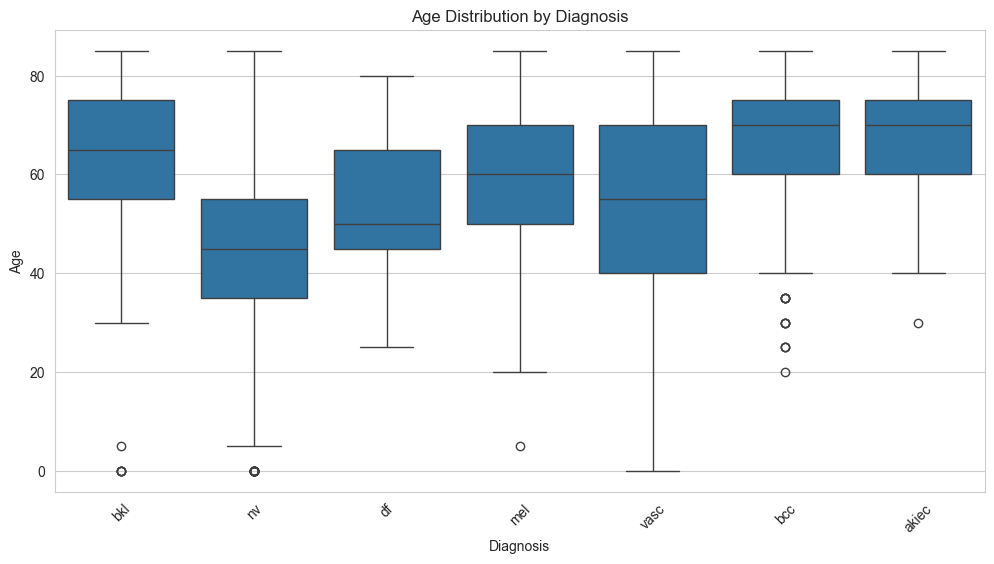

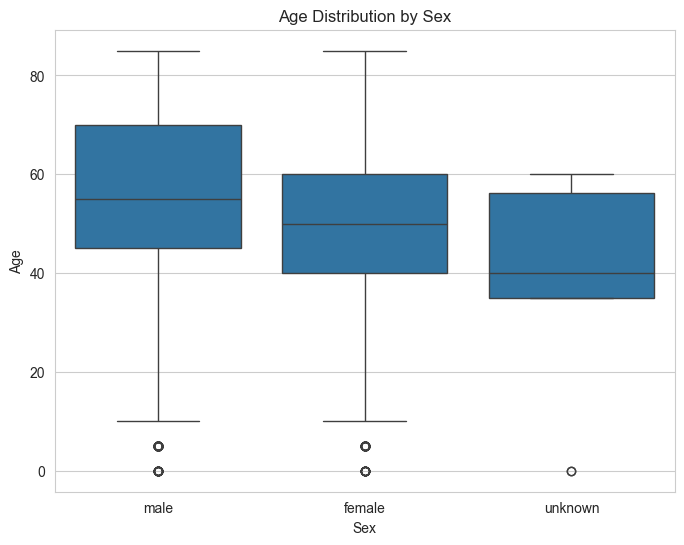

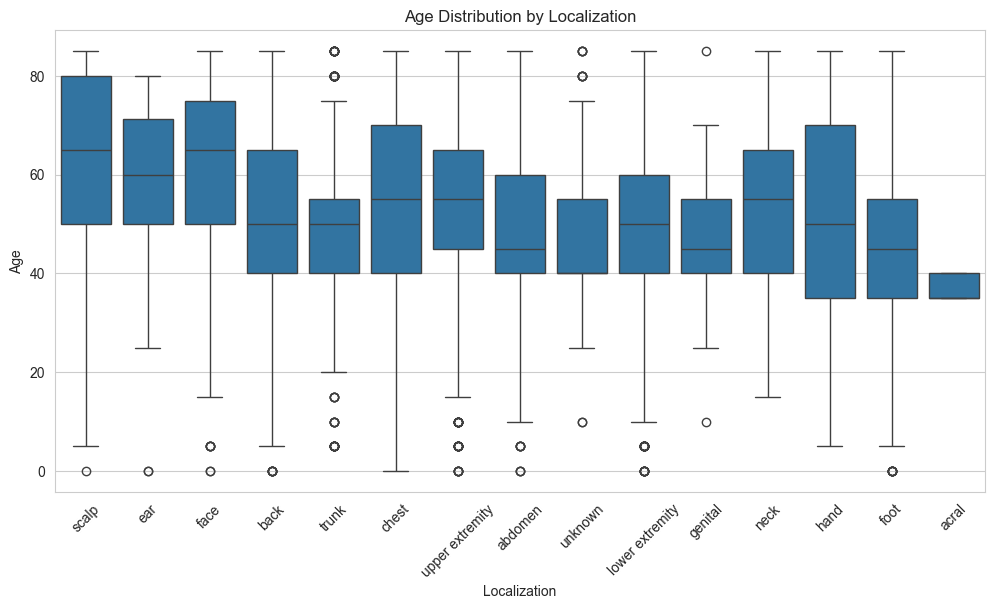

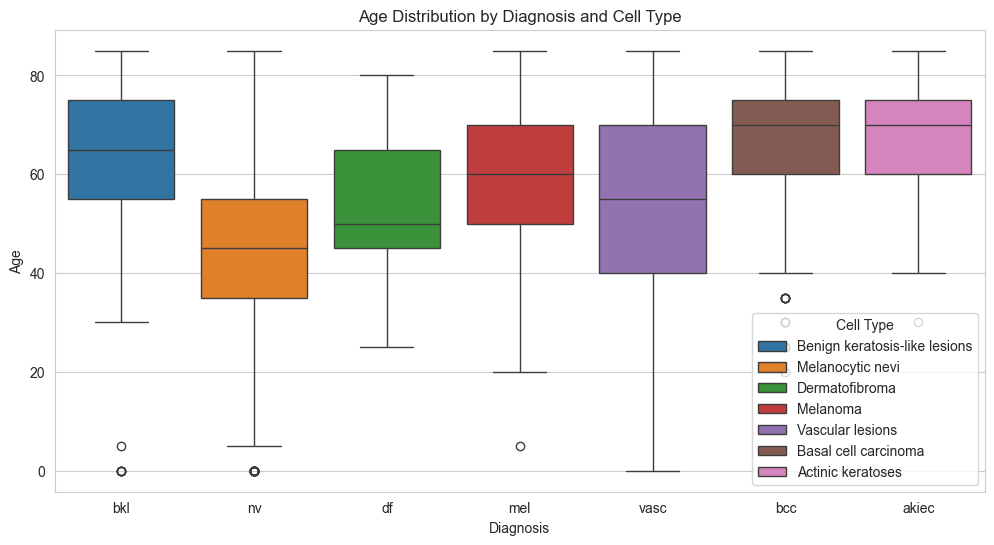

In [58]:
# Box plot for Age distribution by Cell Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='cell_type', y='age', data=df)
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.title('Age Distribution by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Age')
plt.show()

# Box plot for Age distribution by Diagnosis
plt.figure(figsize=(12, 6))
sns.boxplot(x='dx', y='age', data=df)
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.title('Age Distribution by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Age')
plt.show()

# Box plot for Age distribution by Sex
plt.figure(figsize=(8, 6))
sns.boxplot(x='sex', y='age', data=df)
plt.title('Age Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Age')
plt.show()

# Box plot for Age distribution by Localization
plt.figure(figsize=(12, 6))
sns.boxplot(x='localization', y='age', data=df)
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.title('Age Distribution by Localization')
plt.xlabel('Localization')
plt.ylabel('Age')
plt.show()

# Create a box plot to see age distribution by Diagnosis and Cell Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='dx', y='age', hue='cell_type', data=df)
plt.title('Age Distribution by Diagnosis and Cell Type')
plt.xlabel('Diagnosis')
plt.ylabel('Age')
plt.legend(title='Cell Type')
plt.show()

---
### Step 6: Feature Augmentation

#### Add New Images 

In [12]:
tf.random.set_seed(207)
def create_data_generator(datagen, images, labels, batch_size=32):
    datagen.fit(images)
    return datagen.flow(images, labels, batch_size=batch_size)

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator_custom = create_data_generator(datagen, train_images_custom, train_labels_custom)
train_generator_rgb_8 = create_data_generator(datagen, train_images_rgb_8, train_labels_rgb_8)
train_generator_l_8 = create_data_generator(datagen, train_images_l_8, train_labels_l_8)
train_generator_rgb_28 = create_data_generator(datagen, train_images_rgb_28, train_labels_rgb_28)
train_generator_l_28 = create_data_generator(datagen, train_images_l_28, train_labels_l_28)


#### Calculate Class Weights and Augment Data for Minority Classes

In [13]:
tf.random.set_seed(207)
def augment_and_balance_data(train_images_custom, train_labels_custom):
    # Convert one-hot encoded labels to integer labels (class index)
    train_labels_custom = np.argmax(train_labels_custom, axis=1)

    # Compute class weights
    class_labels = np.unique(train_labels_custom)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=class_labels,
        y=train_labels_custom
    )
    class_weight_dict = dict(zip(class_labels, class_weights))
    print("Class Weights:", class_weight_dict)

    # Define the data augmentation pipeline (with random transformation layers)
    data_augmentation_pipeline = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(10 / 360),  # 10 degrees rotation converted to fraction
        tf.keras.layers.RandomZoom(0.1),          # 10% zoom range
        tf.keras.layers.RandomTranslation(0.1, 0.1),  # 10% horizontal and vertical shifts
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Enable horizontal and vertical flips
    ])

    # Get the count of each class
    class_counts = np.bincount(train_labels_custom)
    majority_class_count = np.max(class_counts)
    
    augmented_images = []
    augmented_labels = []

    # Loop over each minority class to generate augmentations to match the majority class size
    for minority_class in np.where(class_counts < majority_class_count)[0]:
        minority_indices = np.where(train_labels_custom == minority_class)[0]
        minority_images = train_images_custom[minority_indices]

        print(f"Minority class {minority_class}: Majority class count = {majority_class_count}, Current count = {len(minority_images)}")

        # Calculate how many augmentations are needed to match the majority class size
        num_augmentations = majority_class_count - len(minority_images)

        # Create augmented images for the minority class
        augmented_class_images = []

        # Ensure that we generate exactly the needed number of augmentations
        while len(augmented_class_images) < num_augmentations:
            # Randomly pick an image from the minority class to augment
            image_to_augment = minority_images[np.random.randint(len(minority_images))]

            # Apply augmentation to the selected image
            augmented_image = data_augmentation_pipeline(image_to_augment[None, ...])[0]  # Apply and remove batch dimension
            augmented_class_images.append(augmented_image)

        # Append the augmented images and their corresponding labels
        augmented_images.append(np.array(augmented_class_images))
        augmented_labels.append(np.full(len(augmented_class_images), minority_class))

    # If there are augmented images, concatenate them with the original dataset
    if augmented_images:
        augmented_images = np.concatenate(augmented_images, axis=0)
        augmented_labels = np.concatenate(augmented_labels, axis=0)
        train_images_balanced = np.concatenate([train_images_custom, augmented_images])
        train_labels_balanced = np.concatenate([train_labels_custom, augmented_labels])
    else:
        train_images_balanced = train_images_custom
        train_labels_balanced = train_labels_custom

    # Shuffle the dataset
    shuffle_indices = np.random.permutation(len(train_images_balanced))
    train_images_balanced = train_images_balanced[shuffle_indices]
    train_labels_balanced = train_labels_balanced[shuffle_indices]

    return train_images_balanced, train_labels_balanced, class_weight_dict


train_images_balanced_custom, train_labels_balanced_custom, class_weight_dict_balanced_custom = augment_and_balance_data(
    train_images_custom, train_labels_custom
)
train_images_balanced_rgb_8, train_labels_balanced_rgb_8, class_weight_dict_balanced_rgb_8 = augment_and_balance_data(
    train_images_rgb_8, train_labels_rgb_8
)
train_images_balanced_l_8, train_labels_balanced_l_8, class_weight_dict_balanced_l_8 = augment_and_balance_data(
    train_images_l_8, train_labels_l_8
)
train_images_balanced_rgb_28, train_labels_balanced_rgb_28, class_weight_dict_balanced_rgb_28 = augment_and_balance_data(
    train_images_rgb_28, train_labels_rgb_28
)
train_images_balanced_l_28, train_labels_balanced_l_28, class_weight_dict_balanced_l_28 = augment_and_balance_data(
    train_images_l_28, train_labels_l_28
)

Class Weights: {0: 4.566109422492401, 1: 2.8709985666507407, 2: 1.2889317889317888, 3: 12.263265306122449, 4: 0.21295672821348832, 5: 1.2679890272209327, 6: 11.005494505494505}
Minority class 0: Majority class count = 4031, Current count = 188
Minority class 1: Majority class count = 4031, Current count = 299
Minority class 2: Majority class count = 4031, Current count = 666
Minority class 3: Majority class count = 4031, Current count = 70
Minority class 5: Majority class count = 4031, Current count = 677
Minority class 6: Majority class count = 4031, Current count = 78
Class Weights: {0: 4.690866510538641, 1: 2.9297903461725987, 2: 1.2736328952946163, 3: 13.625850340136054, 4: 0.21174853759954895, 5: 10.597883597883598, 6: 1.298681651177869}
Minority class 0: Majority class count = 4054, Current count = 183
Minority class 1: Majority class count = 4054, Current count = 293
Minority class 2: Majority class count = 4054, Current count = 674
Minority class 3: Majority class count = 4054,

---
### Step 7: Modeling

### Baseline Model

In [128]:
# YOUR CODE HERE
# Define baseline model
train_labels_1d = np.argmax(train_labels_custom, axis=1)
majority_category = pd.Series(train_labels_1d).value_counts().idxmax()
print("Majority category: ", majority_category)

y_train_pred = np.full(train_labels_custom.shape, 0)
y_train_pred[:, majority_category] = 1

y_val_pred = np.full(val_labels_custom.shape, 0)
y_val_pred[:, majority_category] = 1

train_accuracy = np.sum(np.argmax(train_labels_custom, axis=1) == majority_category) / len(train_labels_custom)
print("Y_train majority class accuracy without balancing dataset:", train_accuracy)

train_labels_balanced_custom_one_hot = tf.keras.utils.to_categorical(train_labels_balanced_custom)
train_labels_balanced_1d = np.argmax(train_labels_balanced_custom_one_hot, axis=1)
majority_balanced_category = pd.Series(train_labels_balanced_1d).value_counts().idxmax()
print("Majority category: ", majority_category)

y_train_balanced_pred = np.full(train_labels_balanced_custom_one_hot.shape, 0)
y_train_balanced_pred[:, majority_category] = 1

train_balanced_accuracy = np.sum(np.argmax(train_labels_balanced_custom_one_hot, axis=1) == majority_balanced_category) / len(train_labels_balanced_custom_one_hot)
print("Y_train majority class accuracy with balancing dataset:", train_balanced_accuracy)



Majority category:  4
Y_train majority class accuracy without balancing dataset: 0.6708270926942919
Majority category:  4
Y_train majority class accuracy with balancing dataset: 0.14285714285714285


### Improvement over Baseline

In [129]:
# Add callback
callbacks = [
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]


---
### Model Type I: Feedforward Neural Network

#### Build Initial Model

In [14]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
def build_model(shape='28l',
                n_classes=7,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # YOUR CODE HERE
    # model = NotImplemented
    model = Sequential()

    # Input layer
    # model.add(Input(shape=(28, 28)))  # Assuming input shape is (28, 28)
    if shape == '8l':
        model.add(Input(shape=(8, 8, 1)))
    elif shape == '8rgb':
        model.add(Input(shape=(8, 8, 3))) 
    elif shape == '28l':
         model.add(Input(shape=(28, 28, 1)))
    elif shape == '28rgb':
        model.add(Input(shape=(28, 28, 3)))
    elif shape == '128rgb':
         model.add(Input(shape=(128, 128, 3))) 
    else:
        raise ValueError("Provide a valid shape: 8, 28, 128.")
            

    # Flatten layer to convert 2D image to 1D vector
    model.add(Flatten())

    # model.add(Input(shape=(784,)))  # Assuming input shape is 784 (28x28 flattened image)

    # Hidden layers
    for units in hidden_layer_sizes:
        model.add(Dense(units, activation=activation))

    # Output layer
    model.add(Dense(n_classes, activation='softmax'))

    # Configure the optimizer
    if optimizer.lower() == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Use 'SGD' or 'Adam'.")

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  # loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

shape of the data:  128rgb
Training the 128rgb model...
Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4986 - loss: 161.4160 - val_accuracy: 0.6772 - val_loss: 31.8437
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5630 - loss: 35.5256 - val_accuracy: 0.6689 - val_loss: 60.3944
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5686 - loss: 51.7662 - val_accuracy: 0.6755 - val_loss: 86.8246
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5796 - loss: 44.5077 - val_accuracy: 0.5275 - val_loss: 68.3471
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5463 - loss: 47.8015 - val_accuracy: 0.6772 - val_loss: 64.8069
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5901 - loss: 41.9403 - val_accuracy: 0.6822 - val_loss: 57.8385
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5794 - loss: 49.0080 - val_accuracy: 0.7022 - val_loss: 48.3496
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

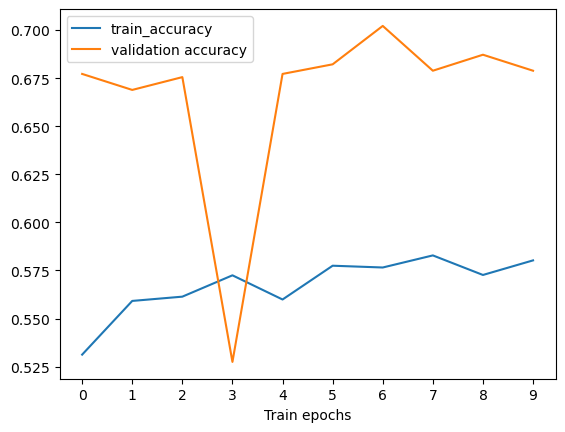

Training accuracy: 0.5803
Validation accuracy: 0.6789


In [15]:
def train_and_evaluate(shape='128rgb',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=10):

  # Build the model.
    model = build_model(shape=shape, n_classes=7,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      metric=metric,
                      learning_rate=learning_rate)

  # Select the dataset.
    print("shape of the data: ",shape)
    if shape == '8l':
        X_train = train_images_l_8
        X_test = test_images_l_8
        Y_train = train_labels_l_8
        Y_test = test_labels_l_8
     
    elif shape == '8rgb':
        X_train = train_images_rgb_8
        X_test = test_images_rgb_8
        Y_train = train_labels_rgb_8
        Y_test = test_labels_rgb_8

    elif shape == '28l':
        X_train = train_images_l_28
        X_test = test_images_l_28
        Y_train = train_labels_l_28
        Y_test = test_labels_l_28
        
    elif shape == '28rgb':
        X_train = train_images_rgb_28
        X_test = test_images_rgb_28
        Y_train = train_labels_rgb_28
        Y_test = test_labels_rgb_28
        
    elif shape == '128rgb':
        X_train = train_images_custom
        X_test = test_images_custom
        Y_train = train_labels_custom
        Y_test = test_labels_custom
    else:
        raise 'Unsupported dataset: %s' %shape

  # Train the model.
    print('Training the', shape, 'model...')
    # print(train_images_l_28.shape)
    # print(train_labels_l_28.shape)

    history = model.fit(
        # x=train_images_l_28,
         x=X_train,
        # y=train_labels_l_28,
         y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=1)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()

    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])

    return model


# run the function
model = train_and_evaluate()

#### Hyperparamter Tuning

In [16]:
# YOUR CODE HERE
#Run experiment

def run_experiment(shape, X_train, Y_train, X_val, Y_val, hidden_sizes, activation, optimizer, learning_rate):
    
    print("Experiment shape:", shape)
    print("Experiment hidden_sizes:", hidden_sizes)
    print("Experiment activation:", activation)
    print("Experiment optimizer:", optimizer)
    model = build_model(shape, n_classes=7, hidden_layer_sizes=hidden_sizes, activation=activation,
                        optimizer=optimizer, learning_rate=learning_rate)


    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                        epochs=10, batch_size=32, verbose=0)

    train_accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]

    return model.count_params(), train_accuracy, val_accuracy

print("Experiment function defined.")

experiments = [
    ([], 'tanh', 'SGD', 0.01),
    ([], 'relu', 'SGD', 0.01),
    ([], 'relu', 'Adam', 0.01),
    ([128], 'relu', 'Adam', 0.01),
    ([256, 128], 'relu', 'Adam', 0.01)
]

results = []

for shape, X_train, Y_train, X_val, Y_val in [
    ('128rgb', train_images_custom, train_labels_custom, val_images_custom, val_labels_custom),
    ('28l', train_images_l_28, train_labels_l_28, val_images_l_28, val_labels_l_28),
   
    ('8l', train_images_l_8, train_labels_l_8, val_images_l_8, val_labels_l_8),
    ('8rgb', train_images_rgb_8, train_labels_rgb_8, val_images_rgb_8, val_labels_rgb_8),
    ('28rgb', train_images_rgb_28, train_labels_rgb_28, val_images_rgb_28, val_labels_rgb_28)
    
]:
    for hidden_sizes, activation, optimizer, learning_rate in experiments:
        params, train_acc, val_acc = run_experiment(shape,X_train, Y_train, X_val, Y_val,
                                                    hidden_sizes, activation, optimizer, learning_rate)
        results.append((shape, hidden_sizes, activation, optimizer, learning_rate,
                        params, train_acc, val_acc))

print("Experiments completed. Results recorded.")

print("Data\tHidden sizes\tActivation\tOptimizer\tLearning rate\t#Parameters\tTraining accuracy\tValidation accuracy")
for result in results:
    print(f"{result[0]}\t{result[1]}\t\t{result[2]}\t\t{result[3]}\t\t{result[4]}\t\t{result[5]}\t\t{result[6]:.4f}\t\t\t{result[7]:.4f}")

Experiment function defined.
Experiment shape: 128rgb
Experiment hidden_sizes: []
Experiment activation: tanh
Experiment optimizer: SGD
Experiment shape: 128rgb
Experiment hidden_sizes: []
Experiment activation: relu
Experiment optimizer: SGD
Experiment shape: 128rgb
Experiment hidden_sizes: []
Experiment activation: relu
Experiment optimizer: Adam
Experiment shape: 128rgb
Experiment hidden_sizes: [128]
Experiment activation: relu
Experiment optimizer: Adam
Experiment shape: 128rgb
Experiment hidden_sizes: [256, 128]
Experiment activation: relu
Experiment optimizer: Adam
Experiment shape: 28l
Experiment hidden_sizes: []
Experiment activation: tanh
Experiment optimizer: SGD
Experiment shape: 28l
Experiment hidden_sizes: []
Experiment activation: relu
Experiment optimizer: SGD
Experiment shape: 28l
Experiment hidden_sizes: []
Experiment activation: relu
Experiment optimizer: Adam
Experiment shape: 28l
Experiment hidden_sizes: [128]
Experiment activation: relu
Experiment optimizer: Adam
E

#### Evaluation and Generalization

In [17]:
# YOUR CODE HERE
import textwrap

# Define the optimal hyperparameters from experiments
optimal_config = {
    'shape':'8l',
    'n_classes': 7,
    'hidden_layer_sizes': [128],
    'activation': 'relu',
    'optimizer': 'Adam',
    'learning_rate': 0.01,
    'metric':'metric'
}

X_train = train_images_l_8
X_test = test_images_l_8
Y_train = train_labels_l_8
Y_test = test_labels_l_8

# Build and compile the model
op_model = build_model(**optimal_config)

# Train the model
history = op_model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

print("Model trained with optimal hyperparameters for digits.")


# Evaluate
# Ensure true labels are converted from one-hot encoding to class indices
train_labels_indices = np.argmax(train_labels_l_8, axis=1)
test_labels_indices = np.argmax(test_labels_l_8, axis=1)

# Generate predictions for training and test sets
train_predictions_probs = op_model.predict(train_images_l_8)
test_predictions_probs = op_model.predict(test_images_l_8)

# Convert probabilities to class predictions
train_predictions = np.argmax(train_predictions_probs, axis=1)
test_predictions = np.argmax(test_predictions_probs, axis=1)

# Calculate train and test accuracy
train_accuracy = accuracy_score(train_labels_indices, train_predictions)
test_accuracy = accuracy_score(test_labels_indices, test_predictions)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Model trained with optimal hyperparameters for digits.
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
Train Accuracy: 0.6751539357630222
Test Accuracy: 0.6640039940089866


#### Confusion Matrix

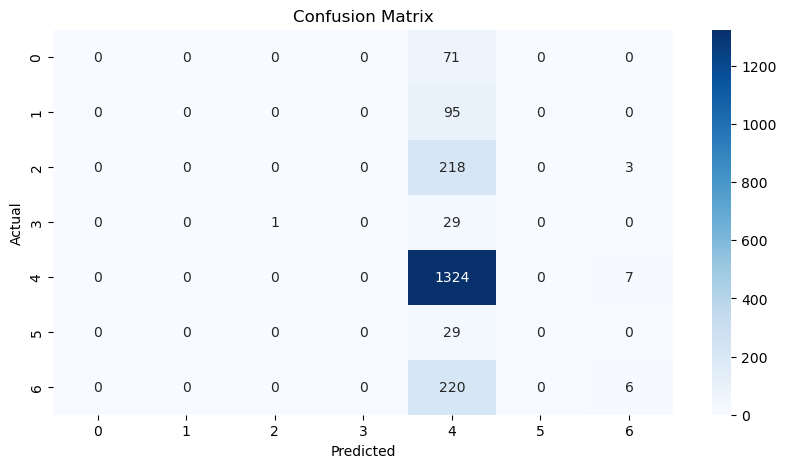

In [18]:
# YOUR CODE HERE
cm = confusion_matrix(test_labels_indices, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(test_labels_indices), 
            yticklabels=np.unique(test_labels_indices))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

---
### Model Type II: Random Forest Model

#### Build Model with Default Parameters

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Reshape the training data
num_samples = train_images_custom.shape[0]  # Number of samples
flattened_features = train_images_custom.shape[1] * train_images_custom.shape[2] * train_images_custom.shape[3]
X_train_128_flat = train_images_custom.reshape(num_samples, flattened_features)

# Flatten X_val
num_samples_val = val_images_custom.shape[0]
X_val_128_flat = val_images_custom.reshape(num_samples_val, flattened_features)

# Flatten X_test
num_samples_test = test_images_custom.shape[0]
X_test_128_flat = test_images_custom.reshape(num_samples_test, flattened_features)


# Assuming you have already split your data and have the following variables:
# X_train, y_train, X_val, y_val (from your previous data splitting step)

# Step 1: Create the RandomForestClassifier model
baseline_classifier = RandomForestClassifier(
    n_estimators=4,
    n_jobs=1,
    random_state=7,
    max_depth=8
)

# Step 2: Fit the model to the training data
baseline_classifier.fit(X_train_128_flat, train_labels_custom)

# Step 3: Make predictions on the validation set
y_train_pred = baseline_classifier.predict(X_train_128_flat)
y_val_pred = baseline_classifier.predict(X_val_128_flat)

train_accuracy = accuracy_score(train_labels_custom, y_train_pred)
val_accuracy = accuracy_score(val_labels_custom, y_val_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

Training Accuracy: 0.7031119986686637
Validation Accuracy: 0.6105841238142786


#### Hyperparameter Tuning

In [20]:
rf_clf2 = RandomForestClassifier(
    n_estimators=25,
    random_state=7,
    n_jobs=1,
    max_depth=7,
    max_features="sqrt",
    min_samples_split=4,
    min_samples_leaf=2
)

# Step 2: Train the model on (X_train_re, y_train)
rf_clf2.fit(X_train_128_flat, train_labels_custom)

# Step 3: Evaluate accuracy on training and validation datasets
y_train_pred = rf_clf2.predict(X_train_128_flat)
y_val_pred = rf_clf2.predict(X_val_128_flat)

train_accuracy = accuracy_score(train_labels_custom, y_train_pred)
val_accuracy = accuracy_score(val_labels_custom, y_val_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

Training Accuracy: 0.6593443168580463
Validation Accuracy: 0.6150773839241138


#### Model Evaluation and Generalization

In [22]:
y_test_pred = rf_clf2.predict(X_test_128_flat)
test_accuracy = accuracy_score(test_labels_custom, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.6115826260609086


#### Confusion Matrix

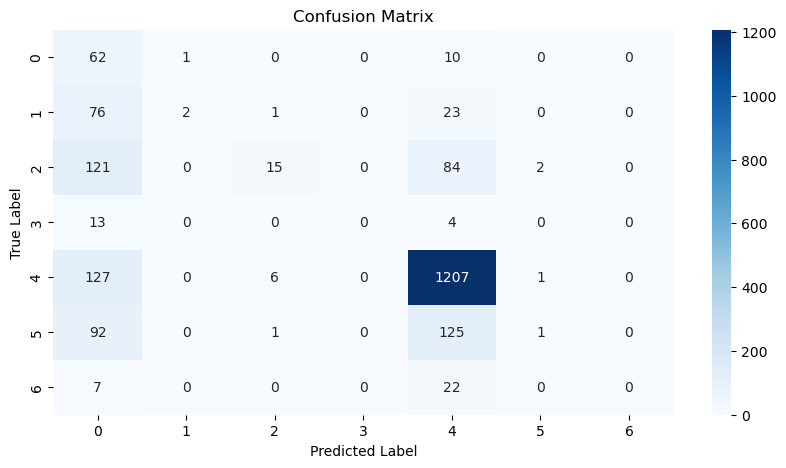

In [24]:
# Convert one-hot encoded labels to single-label format
y_test_single = np.argmax(test_labels_custom, axis=1)
y_pred_single = np.argmax(y_test_pred, axis=1)

from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(y_test_single, y_pred_single)

# Plot the confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test_single), 
            yticklabels=np.unique(y_test_single))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

---
### Model Type III: Convolutional Neural Network

In [130]:
# YOUR CODE HERE
def build_model(input_shape, num_classes=7, pool_size=(2, 2)):
    model_tf = tf.keras.Sequential()
    
    # First convolutional layer
    model_tf.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model_tf.add(layers.MaxPooling2D(pool_size))

    # Second convolutional layer
    model_tf.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model_tf.add(layers.MaxPooling2D(pool_size))

    # Third convolutional layer
    model_tf.add(layers.Conv2D(128, (3, 3), activation='relu'))

    # Forth convolutional layer
    model_tf.add(layers.Conv2D(128, (3, 3), activation='relu'))

    # Fifth convolutional layer
    model_tf.add(layers.Conv2D(128, (3, 3), activation='relu'))

    # Flatten the results to feed into a fully connected layer
    model_tf.add(layers.Flatten())
    model_tf.add(layers.Dense(128, activation='relu'))
    model_tf.add(layers.Dense(num_classes, activation='softmax')) 
     
    model_tf.compile(optimizer=Adam(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    return model_tf


128 x 128 RGB Model:
Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6455 - loss: 1.1251
Epoch 1: val_accuracy improved from -inf to 0.66750, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 105s 554ms/step - accuracy: 0.6456 - loss: 1.1246 - val_accuracy: 0.6675 - val_loss: 0.9710 - learning_rate: 1.0000e-04
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.6738 - loss: 0.9382
Epoch 2: val_accuracy did not improve from 0.66750
188/188 ━━━━━━━━━━━━━━━━━━━━ 121s 630ms/step - accuracy: 0.6738 - loss: 0.9381 - val_accuracy: 0.6670 - val_loss: 0.8841 - learning_rate: 1.0000e-04
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.6751 - loss: 0.8786
Epoch 3: val_accuracy improved from 0.66750 to 0.67898, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 111s 586ms/step - accuracy: 0.6751 - loss: 0.8785 - val_accuracy: 0.6790 - val_loss: 0.9375 - learning_rate: 1.0000e-04
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s

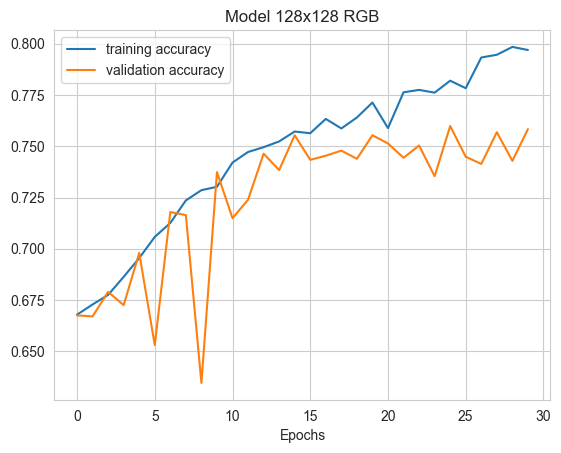

Training accuracy: 0.7970
Validation accuracy: 0.7584


In [63]:
tf.random.set_seed(207)
print('128 x 128 RGB Model:')
history_custom = build_model((128, 128, 3)).fit(train_generator_custom, validation_data=(val_images_custom, val_labels_custom), epochs=30, batch_size=64, callbacks=callbacks)
train_accuracy_custom = history_custom.history['accuracy']
val_accuracy_custom = history_custom.history['val_accuracy']

plt.plot(train_accuracy_custom, label='training accuracy')
plt.plot(val_accuracy_custom, label='validation accuracy')
plt.xlabel('Epochs')
plt.title('Model 128x128 RGB')
plt.legend()
plt.show()
print('Training accuracy: %1.4f' %train_accuracy_custom[-1])
print('Validation accuracy: %1.4f' %val_accuracy_custom[-1])

128 x 128 RGB Balanced Model:
Epoch 1/30
882/882 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.2768 - loss: 5.5341
Epoch 1: val_accuracy did not improve from 0.70344
882/882 ━━━━━━━━━━━━━━━━━━━━ 582s 655ms/step - accuracy: 0.2768 - loss: 5.5329 - val_accuracy: 0.2701 - val_loss: 2.3135 - learning_rate: 1.0000e-04
Epoch 2/30
882/882 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.4669 - loss: 3.4219
Epoch 2: val_accuracy did not improve from 0.70344
882/882 ━━━━━━━━━━━━━━━━━━━━ 544s 617ms/step - accuracy: 0.4669 - loss: 3.4216 - val_accuracy: 0.3600 - val_loss: 2.1021 - learning_rate: 1.0000e-04
Epoch 3/30
882/882 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.5499 - loss: 2.6633
Epoch 3: val_accuracy did not improve from 0.70344
882/882 ━━━━━━━━━━━━━━━━━━━━ 544s 617ms/step - accuracy: 0.5499 - loss: 2.6631 - val_accuracy: 0.4214 - val_loss: 1.9371 - learning_rate: 1.0000e-04
Epoch 4/30
882/882 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.6175 - loss: 2.0985
Epoch 4: val_accur

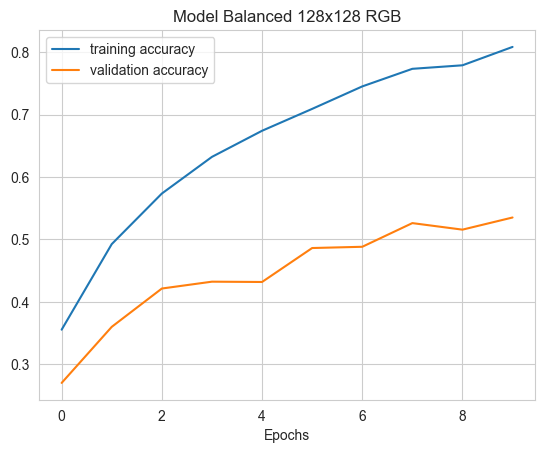

Training accuracy: 0.8086
Validation accuracy: 0.5352


In [136]:
tf.random.set_seed(207)
print('128 x 128 RGB Balanced Model:')
history_balanced_custom = build_model((128, 128, 3)).fit(
    train_images_balanced_custom, 
    train_labels_balanced_custom_one_hot, 
    validation_data=(val_images_custom, val_labels_custom), 
    epochs=30, 
    batch_size=32, 
    callbacks=callbacks,
    class_weight=class_weight_dict_balanced_custom,  
)
train_balanced_accuracy_custom = history_balanced_custom.history['accuracy']
val_balanced_accuracy_custom = history_balanced_custom.history['val_accuracy']

plt.plot(train_balanced_accuracy_custom, label='training accuracy')
plt.plot(val_balanced_accuracy_custom, label='validation accuracy')
plt.xlabel('Epochs')
plt.title('Model Balanced 128x128 RGB')
plt.legend()
plt.show()
print('Training accuracy: %1.4f' %train_balanced_accuracy_custom[-1])
print('Validation accuracy: %1.4f' %val_balanced_accuracy_custom[-1])

In [134]:
def build_model_small(input_shape, num_classes=7, pool_size=(2, 2)):
    model_tf = tf.keras.Sequential()
    
    model_tf.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model_tf.add(layers.MaxPooling2D(pool_size))
    
    model_tf.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model_tf.add(layers.MaxPooling2D(pool_size))
    
    # Flatten and add dense layers
    model_tf.add(layers.Flatten())
    model_tf.add(layers.Dense(128, activation='relu'))
    model_tf.add(layers.Dense(num_classes, activation='softmax'))
    
    model_tf.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model_tf

8 x 8 RGB Model:
Epoch 1/30
178/188 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6099 - loss: 1.3958
Epoch 1: val_accuracy improved from -inf to 0.67199, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6126 - loss: 1.3851 - val_accuracy: 0.6720 - val_loss: 1.0699 - learning_rate: 1.0000e-04
Epoch 2/30
179/188 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6694 - loss: 1.0513
Epoch 2: val_accuracy did not improve from 0.67199
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6694 - loss: 1.0510 - val_accuracy: 0.6720 - val_loss: 1.0086 - learning_rate: 1.0000e-04
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6821 - loss: 1.0018
Epoch 3: val_accuracy did not improve from 0.67199
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6820 - loss: 1.0019 - val_accuracy: 0.6720 - val_loss: 0.9854 - learning_rate: 1.0000e-04
Epoch 4/30
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6651 - loss: 0.9947
Epoch 4: val_acc

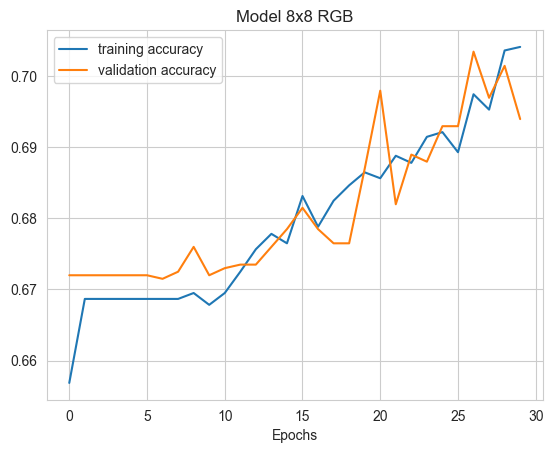

Training accuracy: 0.7041
Validation accuracy: 0.6940
8 x 8 Grayscale Model:
Epoch 1/30
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6120 - loss: 1.3980
Epoch 1: val_accuracy did not improve from 0.70344
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6125 - loss: 1.3961 - val_accuracy: 0.6695 - val_loss: 1.1517 - learning_rate: 1.0000e-04
Epoch 2/30
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6632 - loss: 1.1578
Epoch 2: val_accuracy did not improve from 0.70344
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6633 - loss: 1.1574 - val_accuracy: 0.6695 - val_loss: 1.1419 - learning_rate: 1.0000e-04
Epoch 3/30
178/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6742 - loss: 1.1084
Epoch 3: val_accuracy did not improve from 0.70344
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6741 - loss: 1.1084 - val_accuracy: 0.6695 - val_loss: 1.1291 - learning_rate: 1.0000e-04
Epoch 4/30
183/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6763 - loss

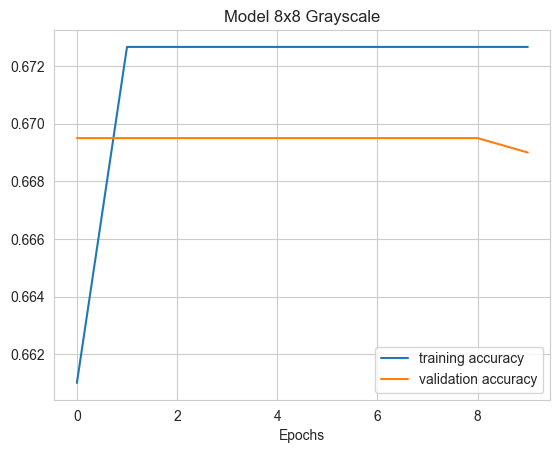

Training accuracy: 0.6727
Validation accuracy: 0.6690


In [135]:
tf.random.set_seed(200)
print('8 x 8 RGB Model:')
history_rgb_8 = build_model_small((8, 8, 3)).fit(train_generator_rgb_8, validation_data=(val_images_rgb_8, val_labels_rgb_8), epochs=30, batch_size=64, callbacks=callbacks)
train_accuracy_rgb_8 = history_rgb_8.history['accuracy']
val_accuracy_rgb_8 = history_rgb_8.history['val_accuracy']

plt.plot(train_accuracy_rgb_8, label='training accuracy')
plt.plot(val_accuracy_rgb_8, label='validation accuracy')
plt.xlabel('Epochs')
plt.title('Model 8x8 RGB')
plt.legend()
plt.show()
print('Training accuracy: %1.4f' %train_accuracy_rgb_8[-1])
print('Validation accuracy: %1.4f' %val_accuracy_rgb_8[-1])


print('8 x 8 Grayscale Model:')
history_l_8 = build_model_small((8, 8, 1)).fit(train_generator_l_8, validation_data=(val_images_l_8, val_labels_l_8), epochs=30, batch_size=64, callbacks=callbacks)
train_accuracy_l_8 = history_l_8.history['accuracy']
val_accuracy_l_8 = history_l_8.history['val_accuracy']

plt.plot(train_accuracy_l_8, label='training accuracy')
plt.plot(val_accuracy_l_8, label='validation accuracy')
plt.xlabel('Epochs')
plt.title('Model 8x8 Grayscale')
plt.legend()
plt.show()
print('Training accuracy: %1.4f' %train_accuracy_l_8[-1])
print('Validation accuracy: %1.4f' %val_accuracy_l_8[-1])

28 x 28 RGB Model:
Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6490 - loss: 1.2126
Epoch 1: val_accuracy did not improve from 0.75986
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6491 - loss: 1.2121 - val_accuracy: 0.6840 - val_loss: 0.9815 - learning_rate: 1.0000e-04
Epoch 2/30
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6705 - loss: 1.0041
Epoch 2: val_accuracy did not improve from 0.75986
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6704 - loss: 1.0039 - val_accuracy: 0.6840 - val_loss: 0.9104 - learning_rate: 1.0000e-04
Epoch 3/30
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6700 - loss: 0.9486
Epoch 3: val_accuracy did not improve from 0.75986
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6700 - loss: 0.9485 - val_accuracy: 0.6835 - val_loss: 0.8710 - learning_rate: 1.0000e-04
Epoch 4/30
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6751 - loss: 0.9008
Epoch 4: val_accuracy did not improve from

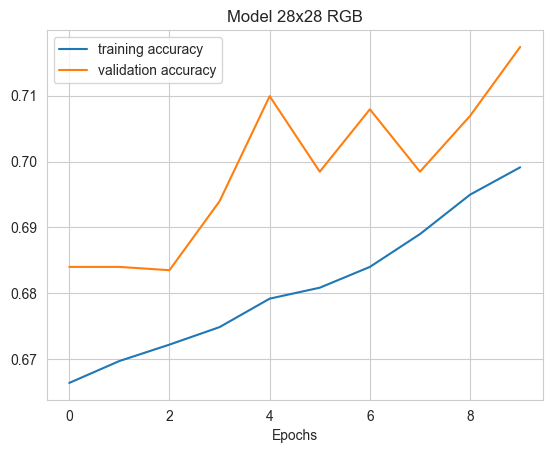

Training accuracy: 0.6991
Validation accuracy: 0.7174
28 x 28 Grayscale Model:
Epoch 1/30
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6499 - loss: 1.2671
Epoch 1: val_accuracy did not improve from 0.75986
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6502 - loss: 1.2654 - val_accuracy: 0.6610 - val_loss: 1.1441 - learning_rate: 1.0000e-04
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6692 - loss: 1.1249
Epoch 2: val_accuracy did not improve from 0.75986
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6692 - loss: 1.1248 - val_accuracy: 0.6630 - val_loss: 1.0980 - learning_rate: 1.0000e-04
Epoch 3/30
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6706 - loss: 1.0894
Epoch 3: val_accuracy did not improve from 0.75986
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6706 - loss: 1.0889 - val_accuracy: 0.6625 - val_loss: 1.0717 - learning_rate: 1.0000e-04
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.67

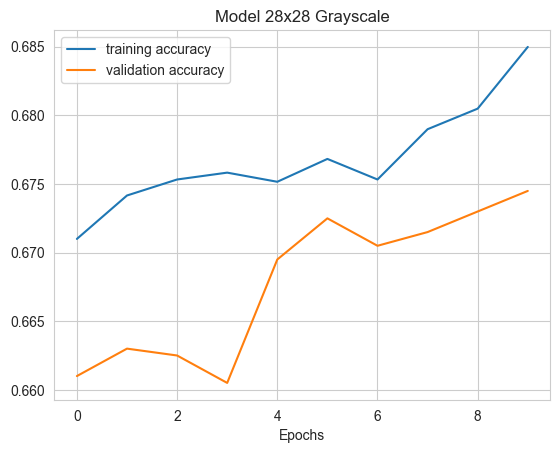

Training accuracy: 0.6850
Validation accuracy: 0.6745


In [71]:
print('28 x 28 RGB Model:')
history_rgb_28 = build_model_small((28, 28, 3)).fit(train_generator_rgb_28, validation_data=(val_images_rgb_28, val_labels_rgb_28), epochs=30, batch_size=64, callbacks=callbacks)
train_accuracy_rgb_28 = history_rgb_28.history['accuracy']
val_accuracy_rgb_28 = history_rgb_28.history['val_accuracy']

plt.plot(train_accuracy_rgb_28, label='training accuracy')
plt.plot(val_accuracy_rgb_28, label='validation accuracy')
plt.xlabel('Epochs')
plt.title('Model 28x28 RGB')
plt.legend()
plt.show()
print('Training accuracy: %1.4f' %train_accuracy_rgb_28[-1])
print('Validation accuracy: %1.4f' %val_accuracy_rgb_28[-1])


print('28 x 28 Grayscale Model:')
history_l_28 = build_model_small((28, 28, 1)).fit(train_generator_l_28, validation_data=(val_images_l_28, val_labels_l_28), epochs=30, batch_size=64, callbacks=callbacks)
train_accuracy_l_28 = history_l_28.history['accuracy']
val_accuracy_l_28 = history_l_28.history['val_accuracy']

plt.plot(train_accuracy_l_28, label='training accuracy')
plt.plot(val_accuracy_l_28, label='validation accuracy')
plt.xlabel('Epochs')
plt.title('Model 28x28 Grayscale')
plt.legend()
plt.show()
print('Training accuracy: %1.4f' %train_accuracy_l_28[-1])
print('Validation accuracy: %1.4f' %val_accuracy_l_28[-1])

In [26]:
print('256 x 256 RGB Model (halted given computing limits)')

def build_cnn_model_3():
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # initialize model
    model_tf = tf.keras.Sequential()
    
    # First convolutional layer
    model_tf.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model_tf.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional layer
    model_tf.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model_tf.add(layers.MaxPooling2D((2, 2)))

    # add dropout layer
    model_tf.add(tf.keras.layers.Dropout(rate=0.3))
    
    # Third convolutional layer
    model_tf.add(layers.Conv2D(256, (3, 3), activation='relu'))

    # Forth convolutional layer
    model_tf.add(layers.Conv2D(256, (3, 3), activation='relu'))

    # Fifth convolutional layer
    model_tf.add(layers.Conv2D(256, (3, 3), activation='relu'))

    # Flatten the results to feed into a fully connected layer
    model_tf.add(layers.Flatten())
    model_tf.add(layers.Dense(256, activation='relu'))
    model_tf.add(layers.Dense(7, activation='softmax'))  

    return model_tf

256 x 256 RGB Model (halted given computing limits)


#### Evaluation and Generalization

In [74]:
# YOUR CODE HERE
# Ensure true labels are converted from one-hot encoding to class indices
train_labels_indices = np.argmax(train_labels_custom, axis=1)
test_labels_indices = np.argmax(test_labels_custom, axis=1)

# Use the model from history_custom
model = history_custom.model

# Generate predictions for training and test sets
train_predictions_probs = model.predict(train_images_custom)
test_predictions_probs = model.predict(test_images_custom)

# Convert probabilities to class predictions
train_predictions = np.argmax(train_predictions_probs, axis=1)
test_predictions = np.argmax(test_predictions_probs, axis=1)

# Calculate train and test accuracy
train_accuracy = accuracy_score(train_labels_indices, train_predictions)
test_accuracy = accuracy_score(test_labels_indices, test_predictions)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 136ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step
Train Accuracy: 0.8012980529206191
Test Accuracy: 0.7668497254118821


#### Confusion Matrix

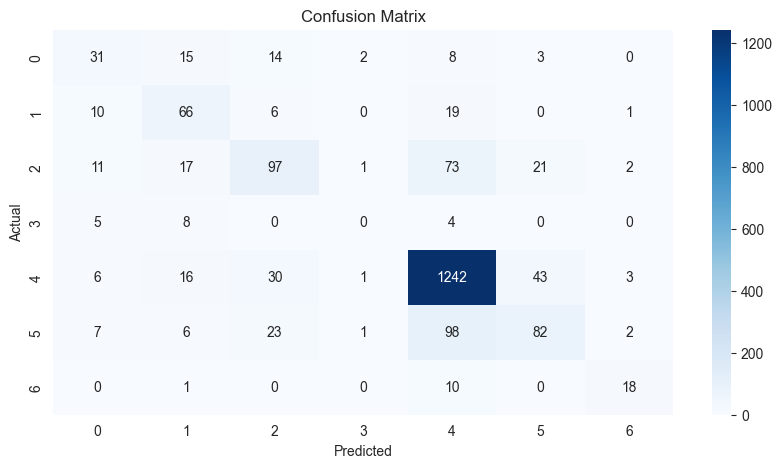

In [78]:
# YOUR CODE HERE
cm = confusion_matrix(test_labels_indices, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(test_labels_indices), 
            yticklabels=np.unique(test_labels_indices))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [79]:
from sklearn.metrics import precision_score, recall_score
# Calculate Precision
precision = precision_score(test_labels_indices, test_predictions, average=None)

# Find the class with the lowest precision
lowest_precision_index = np.argmin(precision)
lowest_precision_value = precision[lowest_precision_index]

print(f'Lowest Precision Class: {lowest_precision_index}')
print(f'Precision: {lowest_precision_value}')

# Calculate Recall
recall = recall_score(test_labels_indices, test_predictions, average=None)

# Find the class with the lowest recall
lowest_recall_index = np.argmin(recall)
lowest_recall_value = recall[lowest_recall_index]

print(f'Lowest Recall Class: {lowest_recall_index}')
print(f'Recall: {lowest_recall_value}')

Lowest Precision Class: 3
Precision: 0.0
Lowest Recall Class: 3
Recall: 0.0
